# Chunking Strategies for RAG Systems: A Comprehensive Guide

![Chunking Illustration](https://raw.githubusercontent.com/brandonstarxel/chunking_evaluation/main/media/chunking.png)

## Introduction

Chunking is a critical component in the RAG (Retrieval Augmented Generation) ecosystem. It's the process of splitting text into manageable pieces that can be embedded into your vector database for efficient retrieval. While many RAG implementations use a single chunking method, research shows that the chunking strategy you choose can significantly impact retrieval performance.

This lab explores different chunking strategies, from simple character-based approaches to advanced semantic methods, to help you find the optimal strategy for your RAG applications.

## Why Chunking Matters

When building a RAG system, chunking affects:

1. **Retrieval accuracy**: The right chunks ensure relevant information is retrieved for user queries
2. **Context preservation**: Proper chunking maintains the semantic coherence of information
3. **Token efficiency**: Optimized chunks reduce the number of irrelevant or redundant tokens
4. **Processing performance**: Well-designed chunks improve embedding and retrieval speed

Poorly chosen chunking strategies can lead to information loss, irrelevant retrieval results, and increased costs due to processing unnecessary tokens.

## Setup and Dependencies

We'll use the `chunking_evaluation` library developed by ChromaDB researchers to implement and compare different chunking strategies. This library provides implementations of traditional chunking methods as well as novel approaches like Cluster Semantic Chunking and LLM Semantic Chunking.

In [19]:
# Install the chunking_evaluation library
!pip install git+https://github.com/brandonstarxel/chunking_evaluation.git

# Import the necessary chunking functions
from chunking_evaluation.chunking import (
    FixedTokenChunker,
    RecursiveTokenChunker,
    KamradtModifiedChunker,
    ClusterSemanticChunker,
    LLMSemanticChunker
)

# Additional dependencies
import os
import json
import tiktoken
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from chromadb.utils import embedding_functions
from chunking_evaluation.utils import openai_token_count

# Import our custom visualization helper
from chunk_visualizer import (
    visualize_chunks_html, 
    analyze_chunks_stats, 
    plot_chunk_stats, 
    save_chunks_to_json,
    setup_chunking_output
)

# Create the base output directory if it doesn't exist
os.makedirs("output", exist_ok=True)

  Cloning https://github.com/brandonstarxel/chunking_evaluation.git to /private/var/folders/_z/ms9rqjt90dq1s5797l_x0ry40000gn/T/pip-req-build-abj0lkxo
  Running command git clone --filter=blob:none --quiet https://github.com/brandonstarxel/chunking_evaluation.git /private/var/folders/_z/ms9rqjt90dq1s5797l_x0ry40000gn/T/pip-req-build-abj0lkxo
  Resolved https://github.com/brandonstarxel/chunking_evaluation.git to commit d451fc4cf56e417b755994b4ca5212fd5057c0d2
  Preparing metadata (setup.py) ... done


## Sample Document for Chunking

Throughout this lab, we'll use a sample document about artificial intelligence to demonstrate different chunking strategies. Let's load it and take a look:

In [20]:
# Load the sample document
with open("chroma-chunking-report.md", 'r', encoding='utf-8') as file:
    document = file.read()

# Print the first 500 characters to see what we're working with
print("First 500 characters: ", document[:500])

# Get the total token count
encoding = tiktoken.get_encoding("cl100k_base")
tokens = encoding.encode(document)
print(f"Total document length: {len(tokens)} tokens")

First 500 characters:  Title: Evaluating Chunking Strategies for Retrieval

URL Source: https://research.trychroma.com/evaluating-chunking

Markdown Content:
Chunking is a commonly used pre-processing step when ingesting documents for retrieval in the context of AI applications. Chunking serves to divide documents into units of information, with semantic content suitable for embeddings-based retrieval and processing by an LLM.

The purpose of this technical report is to evaluate the impact of the choice of chunking st
Total document length: 30544 tokens


## Helper Functions

Before diving into chunking strategies, let's define some helper functions to analyze chunks:

In [21]:
def analyze_chunks(chunks, use_tokens=False):
    """
    Analyze a list of chunks to show statistics and overlaps.
    
    Args:
        chunks: List of text chunks
        use_tokens: Whether to analyze overlap by tokens instead of characters
    """
    # Print basic stats
    print("\nNumber of Chunks:", len(chunks))
    
    # Show examples of chunks
    if len(chunks) >= 2:
        print("\n", "="*50, f"Chunk #{len(chunks)//3}", "="*50)
        print(chunks[len(chunks)//3])
        print("\n", "="*50, f"Chunk #{2*len(chunks)//3}", "="*50)
        print(chunks[2*len(chunks)//3])
    
    # Calculate average chunk size
    if use_tokens:
        encoding = tiktoken.get_encoding("cl100k_base")
        chunk_sizes = [len(encoding.encode(chunk)) for chunk in chunks]
        print(f"\nAverage chunk size: {sum(chunk_sizes)/len(chunk_sizes):.1f} tokens")
        print(f"Min chunk size: {min(chunk_sizes)} tokens")
        print(f"Max chunk size: {max(chunk_sizes)} tokens")
    else:
        chunk_sizes = [len(chunk) for chunk in chunks]
        print(f"\nAverage chunk size: {sum(chunk_sizes)/len(chunk_sizes):.1f} characters")
        print(f"Min chunk size: {min(chunk_sizes)} characters")
        print(f"Max chunk size: {max(chunk_sizes)} characters")
    
    # Find overlaps if there are at least two chunks
    if len(chunks) >= 2:
        chunk1, chunk2 = chunks[len(chunks)//2], chunks[len(chunks)//2 + 1]
        
        if use_tokens:
            encoding = tiktoken.get_encoding("cl100k_base")
            tokens1 = encoding.encode(chunk1)
            tokens2 = encoding.encode(chunk2)
            
            # Find overlapping tokens
            for i in range(min(len(tokens1), 50), 0, -1):
                if tokens1[-i:] == tokens2[:i]:
                    overlap = encoding.decode(tokens1[-i:])
                    print("\n", "="*50, f"\nOverlapping text ({i} tokens):", overlap)
                    return
            print("\nNo token overlap found")
        else:
            # Find overlapping characters
            for i in range(min(len(chunk1), 200), 0, -1):
                if chunk1[-i:] == chunk2[:i]:
                    print("\n", "="*50, f"\nOverlapping text ({i} chars):", chunk1[-i:])
                    return
            print("\nNo character overlap found")

## Basic Chunking Strategies

### 1. Character-Based Chunking

The simplest form of chunking is to split text based on character count. This approach divides the text into chunks of a specified number of characters, with an optional overlap to maintain context between chunks.


Number of Chunks: 101

 ================================================== Chunk #33 ==================================================
y is set to any distance above the 95th percentile of all consecutive distances. This is a relative metric and can lead to larger chunks in bigger corpora.

★ KamradtModifiedChunker#
-------------------------

It is desirable for users to be able to set the chunk length directly, in order to ensure that chunks fit within the context window of the embedding model. To address this, we modify the `KamradtSemanticChunker` by implementing a binary search over discontinuity thresholds such that the largest chunk is shorter than the specified length.

★ ClusterSemanticChunker#
-------------------------

We further extend the principle of embeddings-based semantic chunking by observing that the `KamradtSemanticChunker` algorithm is greedy in nature, which may not produce the optimal chunking under

 ================================================== Chunk #67

'output/character_chunking/stats.png'

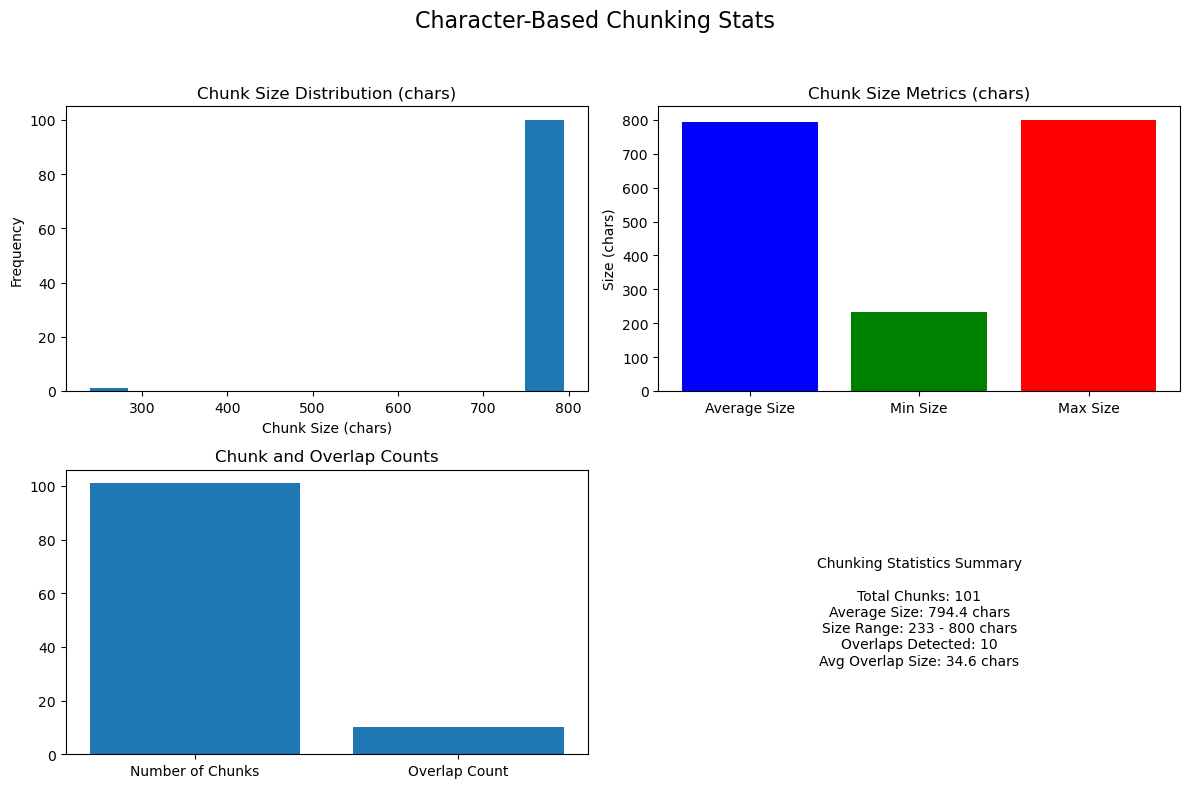

In [13]:
def character_chunk_text(document, chunk_size, overlap):
    """
    Split text into chunks based on character count.
    
    Args:
        document: Text to split
        chunk_size: Maximum number of characters per chunk
        overlap: Number of overlapping characters between chunks
    
    Returns:
        List of text chunks
    """
    chunks = []
    stride = chunk_size - overlap
    current_idx = 0
    
    while current_idx < len(document):
        # Take chunk_size characters starting from current_idx
        chunk = document[current_idx:current_idx + chunk_size]
        if not chunk:  # Break if we're out of text
            break
        chunks.append(chunk)
        current_idx += stride  # Move forward by stride
    
    return chunks

# Set up output directory for character chunking
strategy_name = "character_chunking"
output_dir = setup_chunking_output(strategy_name)

# Example: Chunk size of 800 characters, no overlap
char_chunks = character_chunk_text(document, chunk_size=800, overlap=0)
analyze_chunks(char_chunks)

# Save chunks to JSON
save_chunks_to_json(char_chunks, strategy_name)

# Example: Chunk size of 800 characters, 400 character overlap
char_overlap_chunks = character_chunk_text(document, chunk_size=800, overlap=400)
analyze_chunks(char_overlap_chunks)

# Save overlap chunks to JSON
save_chunks_to_json(char_overlap_chunks, f"{strategy_name}_with_overlap")

# Visualize character chunks
visualize_chunks_html(
    document, 
    char_chunks, 
    output_path="visualization.html", 
    title="Character-Based Chunking", 
    strategy_name=strategy_name
)
visualize_chunks_html(
    document, 
    char_chunks, 
    output_path="visualization-overlap.html", 
    title="Character-Based Overlap Chunking", 
    strategy_name=strategy_name
)

# Generate and plot statistics
stats = analyze_chunks_stats(char_chunks)
plot_chunk_stats(
    stats, 
    title="Character-Based Chunking Stats", 
    output_path="stats.png", 
    strategy_name=strategy_name
)

**Pros of Character-Based Chunking:**
- Simple to implement and understand
- Predictable chunk sizes
- Works with any text content

**Cons of Character-Based Chunking:**
- May split text in the middle of sentences or paragraphs
- Doesn't account for semantic meaning
- Inconsistent token counts (important for LLM context limits)

### 2. Token-Based Chunking

Token-based chunking is similar to character-based chunking but uses tokens (the units used by language models) instead of characters. This approach ensures chunks fit within token limits for LLMs.

In [14]:
# Set up output directory for token chunking
strategy_name = "token_chunking"
output_dir = setup_chunking_output(strategy_name)

# Using FixedTokenChunker from the chunking_evaluation library
fixed_token_chunker = FixedTokenChunker(
    chunk_size=400,  # 400 tokens per chunk 
    chunk_overlap=0,  # No overlap
    encoding_name="cl100k_base"  # Use OpenAI's cl100k tokenizer
)

token_chunks = fixed_token_chunker.split_text(document)
analyze_chunks(token_chunks, use_tokens=True)

# Save chunks to JSON
save_chunks_to_json(token_chunks, strategy_name)

# With overlap
token_overlap_chunker = FixedTokenChunker(
    chunk_size=400, 
    chunk_overlap=200,  # 200 token overlap
    encoding_name="cl100k_base"
)

token_overlap_chunks = token_overlap_chunker.split_text(document)
analyze_chunks(token_overlap_chunks, use_tokens=True)

# Save overlap chunks to JSON
save_chunks_to_json(token_overlap_chunks, f"{strategy_name}_with_overlap")

# Visualize token chunks
visualize_chunks_html(
    document, 
    token_chunks, 
    output_path="visualization.html", 
    title="Token-Based Chunking", 
    strategy_name=strategy_name
)

# Generate and plot statistics
stats = analyze_chunks_stats(token_chunks, use_tokens=True)
plot_chunk_stats(
    stats, 
    title="Token-Based Chunking Stats", 
    output_path="stats.png", 
    strategy_name=strategy_name
)


Number of Chunks: 77

 ================================================== Chunk #25 ==================================================
, all-MiniLM-L6-v2. https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2 2024. Accessed: 2024-06-27.

\[27\] Kristian Georgiev Aleksander Madry Benjamin Cohen-Wang, Harshay Shah. Contextcite: Attributing model generation to context. https://github.com/MadryLab/context-cite/tree/main, 2024.

Appendices#
-----------

Synthetic Dataset Prompt#
-------------------------

> You are an agent that generates questions from provided text. Your job is to generate a question and provide the relevant sections from the text as references.
> 
> Instructions:
> 
> 1.  For each provided text, generate a question that can be answered solely by the facts in the text.
> 2.  Extract all significant facts that answer the generated question.
> 3.  Format the response in JSON format with two fields:
> 
> *   'question': A question directly related to these facts, en

KeyboardInterrupt: 

**Pros of Token-Based Chunking:**
- Chunks fit precisely within LLM token limits
- More predictable in terms of processing requirements
- Better aligned with how LLMs process text

**Cons of Token-Based Chunking:**
- Still may split text at semantically inappropriate points
- Requires a tokenizer that matches your LLM
- Doesn't consider document structure

## Advanced Chunking Strategies

### 3. Recursive Character/Token Chunking

The recursive approach improves on basic chunking by trying to split text at natural boundaries (paragraphs, sentences, etc.) while respecting a maximum size limit.

In [23]:
# Set up output directory for recursive chunking
strategy_name = "recursive_chunking"
output_dir = setup_chunking_output(strategy_name)

# Using RecursiveTokenChunker from the chunking_evaluation library
recursive_token_chunker = RecursiveTokenChunker(
    chunk_size=400,  # Maximum token count
    chunk_overlap=0,  # No overlap
    length_function=openai_token_count,  # Function to count tokens
    separators=["\n\n", "\n", ".", "?", "!", " ", ""]  # Try these separators in order
)

recursive_token_chunks = recursive_token_chunker.split_text(document)
analyze_chunks(recursive_token_chunks, use_tokens=True)

# Save chunks to JSON
save_chunks_to_json(recursive_token_chunks, strategy_name)

# With overlap
recursive_token_overlap_chunker = RecursiveTokenChunker(
    chunk_size=400,
    chunk_overlap=200,
    length_function=openai_token_count,
    separators=["\n\n", "\n", ".", "?", "!", " ", ""]
)

recursive_token_overlap_chunks = recursive_token_overlap_chunker.split_text(document)
analyze_chunks(recursive_token_overlap_chunks, use_tokens=True)

# Save overlap chunks to JSON
save_chunks_to_json(recursive_token_overlap_chunks, f"{strategy_name}_with_overlap")

# Visualize recursive token chunks
visualize_chunks_html(
    document, 
    recursive_token_chunks, 
    output_path="visualization.html", 
    title="Recursive Token Chunking", 
    strategy_name=strategy_name
)

# Generate and plot statistics
stats = analyze_chunks_stats(recursive_token_chunks, use_tokens=True)
plot_chunk_stats(
    stats, 
    title="Recursive Token Chunking Stats", 
    output_path="stats.png", 
    strategy_name=strategy_name
)


Number of Chunks: 102

 ================================================== Chunk #34 ==================================================
Where Y is a random variable representing the next token, yt is the t\-th possible token and P(yt) is the probability assigned to token (yt). We observe that in general, token entropy rises at the beginning and towards the end of sentences, as well as after a verb after which any noun or adjective could be expected. We initially expected that the entropy would rise as the theme of the text changes, however, we find that the LLM quickly refocuses between topics and so we did not extract a clear signal for semantic boundaries.

We also did not find that there was any clear structure in the attention values which could be used for chunking.

### ContextCite Inspired Chunking#

The final algorithm was inspired by ContextCite \[[27](https://research.trychroma.com/evaluating-chunking#cohenwang2024contextcite)\]. Their work leverages next-token prediction to

KeyboardInterrupt: 

**Pros of Recursive Chunking:**
- Preserves natural text boundaries when possible
- More semantically coherent chunks
- Adaptable to different document structures
- Respects both maximum size and contextual boundaries

**Cons of Recursive Chunking:**
- Chunk sizes can vary significantly
- More complex implementation
- May still make suboptimal splits in some cases

### 4. Semantic Chunking (Kamradt Method)

Semantic chunking uses embeddings to find natural semantic boundaries in the text. The Kamradt method looks for discontinuities in embedding similarity to identify good split points.

In [22]:
# Check if OpenAI API key is set
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    print("Warning: OPENAI_API_KEY environment variable is not set. Skipping semantic chunking strategies.")
else:
    # Set up output directory for semantic chunking
    strategy_name = "kamradt_chunking"
    output_dir = setup_chunking_output(strategy_name)
    
    # Set up an embedding function
    embedding_function = embedding_functions.OpenAIEmbeddingFunction(
        api_key=api_key, 
        model_name="text-embedding-3-small"
    )
    
    # Using KamradtModifiedChunker from the chunking_evaluation library
    kamradt_chunker = KamradtModifiedChunker(
        avg_chunk_size=300,      # Target size in tokens
        min_chunk_size=50,       # Initial split size
        embedding_function=embedding_function  # Pass your embedding function
    )
    
    kamradt_chunks = kamradt_chunker.split_text(document)
    analyze_chunks(kamradt_chunks, use_tokens=True)
    
    # Save chunks to JSON
    save_chunks_to_json(kamradt_chunks, strategy_name)
    
    # Visualize semantic chunks
    visualize_chunks_html(
        document, 
        kamradt_chunks, 
        output_path="visualization.html", 
        title="Kamradt Semantic Chunking", 
        strategy_name=strategy_name
    )
    
    # Generate and plot statistics
    stats = analyze_chunks_stats(kamradt_chunks, use_tokens=True)
    plot_chunk_stats(
        stats, 
        title="Kamradt Semantic Chunking Stats", 
        output_path="stats.png", 
        strategy_name=strategy_name
    )


Number of Chunks: 102

 ================================================== Chunk #34 ==================================================
.3 | | TokenText | 800 | 400 | 5 | 79.3 ± 40.4 | 1.0 ± 1.1 | 3.9 ± 3.0 | 1 .0 ± 1.1 | | Recursive | 400 | 200 | 5 | 81.3 ± 37.5 | 2.7 ± 2.5 | 12.0 ± 9.2 | 2.7 ± 2 .5 | | TokenText | 400 | 200 | 5 | **86.0 ± 34.0** | 2.2 ± 2.1 | 7.0 ± 5.3 | 2 .2 ± 2.1 | | Recursive | 400 | 0 | 5 | 84.0 ± 35.4 | 3.4 ± 4.3 | 17.4 ± 18.7 | 3.4 ± 4 .3 | | TokenText | 400 | 0 | 5 | 83.6 ± 35.5 | 2.1 ± 2.1 | 10.0 ± 8.0 | 2 .1 ± 2.1 | | Recursive | 200 | 0 | 5 | 79.6 ± 38.4 | **5.9 ± 5.6** | **27.1 ± 18.6** | **5 .9 ± 5.6** | | TokenText | 200 | 0 | 5 | 83.7 ± 35.3 | 4.2 ± 4.0 | 17.2 ± 13.2 | 4 .2 ± 3.9 | | Cluster | 400 | 0 | 5 | 85.1 ± 33.9 | 2.8 ± 2.3 | 14.0 ± 10.8 | 2.8 ± 2 .3 |

 ================================================== Chunk #68 ==================================================
.8 ± 5.5 | | Recursive | 250 | 0 | Min | 70.5 ± 42.5 | 18.7 ± 16.0 | 25.0 ± 12.7 |

KeyboardInterrupt: 

**Pros of Semantic Chunking:**
- Creates chunks based on semantic content, not just character position
- Better maintains conceptual unity within chunks
- Can identify natural topic transitions

**Cons of Semantic Chunking:**
- Requires embedding model, adding complexity and cost
- More computationally intensive
- Results vary based on embedding quality

### 5. Cluster Semantic Chunking

Cluster Semantic Chunking takes a global optimization approach, considering relationships between all pieces of text simultaneously to find optimal chunks.

In [24]:
# Check if OpenAI API key is set
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    print("Warning: OPENAI_API_KEY environment variable is not set. Skipping cluster semantic chunking strategies.")
else:
    # Set up output directory for cluster semantic chunking
    strategy_name = "cluster_chunking"
    output_dir = setup_chunking_output(strategy_name)
    
    # Using ClusterSemanticChunker from the chunking_evaluation library
    cluster_chunker = ClusterSemanticChunker(
        embedding_function=embedding_function, 
        max_chunk_size=300,  # Maximum chunk size in tokens
        length_function=openai_token_count
    )
    
    cluster_chunks = cluster_chunker.split_text(document)
    analyze_chunks(cluster_chunks, use_tokens=True)
    
    # Save chunks to JSON
    save_chunks_to_json(cluster_chunks, strategy_name)
    
    # Visualize cluster semantic chunks
    visualize_chunks_html(
        document, 
        cluster_chunks, 
        output_path="visualization.html", 
        title="Cluster Semantic Chunking", 
        strategy_name=strategy_name
    )
    
    # Generate and plot statistics
    stats = analyze_chunks_stats(cluster_chunks, use_tokens=True)
    plot_chunk_stats(
        stats, 
        title="Cluster Semantic Chunking Stats", 
        output_path="stats.png", 
        strategy_name=strategy_name
    )


Number of Chunks: 307

 ================================================== Chunk #102 ==================================================
. _arXiv preprint arXiv:1611.09268_. https://arxiv.org/abs/1611.09268

 ================================================== Chunk #204 ==================================================
| Cluster | 400 | 0 | 5 | 98.3 ± 11.5 | 3.4 ± 2.3 | 15.9 ± 11.4 | 3.4 ± 2 .3 | | Cluster | 200 | 0 | 5 | 97.6 ± 12.1 | **6.1 ± 4.1** | **28.5 ± 16.9** | **6 .1 ± 4.1** | | LLM | N/A | 0 | 5 | 97.3 ± 16.0 | 3.3 ± 3.0 | 18.0 ± 15.4 | 3 .3 ± 3.0 |

Average chunk size: 99.6 tokens
Min chunk size: 1 tokens
Max chunk size: 231 tokens

No token overlap found
Chunks saved to output/cluster_chunking/chunks.json
Chunk visualization saved to output/cluster_chunking/visualization.html


KeyboardInterrupt: 

**Pros of Cluster Semantic Chunking:**
- Global optimization considers all text relationships
- Creates more coherent groupings than local methods
- Can recognize related content even when separated by brief topic shifts

**Cons of Cluster Semantic Chunking:**
- Most computationally expensive
- Requires recomputation when adding new data
- More complex to implement and tune

### 6. LLM Semantic Chunking

LLM Semantic Chunking directly asks a language model to identify meaningful semantic boundaries in the text.

In [25]:
# Check if OpenAI API key is set
api_key = os.environ.get("OPENAI_API_KEY")
if not api_key:
    print("Warning: OPENAI_API_KEY environment variable is not set. Skipping LLM semantic chunking strategies.")
else:
    # Set up output directory for LLM semantic chunking
    strategy_name = "llm_chunking"
    output_dir = setup_chunking_output(strategy_name)
    
    # Using LLMSemanticChunker from the chunking_evaluation library
    llm_chunker = LLMSemanticChunker(
        organisation="openai", 
        model_name="gpt-3.5-turbo", 
        api_key=api_key
    )
    
    llm_chunks = llm_chunker.split_text(document)
    analyze_chunks(llm_chunks, use_tokens=True)
    
    # Save chunks to JSON
    save_chunks_to_json(llm_chunks, strategy_name)
    
    # Visualize LLM semantic chunks
    visualize_chunks_html(
        document, 
        llm_chunks, 
        output_path="visualization.html", 
        title="LLM Semantic Chunking", 
        strategy_name=strategy_name
    )
    
    # Generate and plot statistics
    stats = analyze_chunks_stats(llm_chunks, use_tokens=True)
    plot_chunk_stats(
        stats, 
        title="LLM Semantic Chunking Stats", 
        output_path="stats.png", 
        strategy_name=strategy_name
    )

Processing chunks: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 1096/1098 [00:40<00:00, 27.05it/s]



Number of Chunks: 175

 ================================================== Chunk #58 ==================================================
| Kamradt | N/A (~660) | 0 | 83.6 ± 36.8 | 1.5 ± 1.6 | 7.4 ± 10.2 | 1 .5 ± 1.6 | | ★ KamradtMod | 300 (~397) | 0 | 87.1 ± 31.9 | 2.1 ± 2.0 | 10.5 ± 12.3 | 2

 ================================================== Chunk #116 ==================================================
.4 | | Cluster | 400 | 0 | Min | 58.9 ± 48.3 | 6.6 ± 9.3 | 14.0 ± 10.8 | 6.6 ± 9 .3 | | Cluster | 200 | 0 | Min | 63.5 ± 47.1 | 11.6 ± 14.5 | 24.4 ± 17.1 | 11.6 ± 14 .4 | | LLM | N/A | 0 | Min | 49.4 ± 49.5 | 5.9 ± 9.7 | 13.6 ± 11.6 | 5.9 ± 9 .7 | |  |  |  |  |  |  |  |  | | Recursive | 800 | 400 | 5 | 74.2 ± 43.2 | 1.1 ± 1.3 | 6.9 ± 6.0 | 1.1 ± 1

Average chunk size: 174.7 tokens
Min chunk size: 3 tokens
Max chunk size: 767 tokens

No token overlap found
Chunks saved to output/llm_chunking/chunks.json
Chunk visualization saved to output/llm_chunking/visualization.html


KeyboardInterrupt: 

**Pros of LLM Semantic Chunking:**
- Leverages LLM's understanding of language and content
- Can adapt to different document types and styles
- Potentially identifies the most natural semantic boundaries

**Cons of LLM Semantic Chunking:**
- Requires LLM API, adding significant cost
- Slowest method, especially for large documents
- Results vary based on the LLM and prompt used

## Comparing Chunking Strategies

Let's compare the different chunking strategies on our document to see how they perform:

In [10]:
# Function to extract metrics from different chunking strategies
def compare_chunkers(document):
    chunking_results = {}
    
    # Character chunking (800 chars, no overlap)
    char_chunks = character_chunk_text(document, chunk_size=800, overlap=0)
    chunking_results["Character (800)"] = {
        "num_chunks": len(char_chunks),
        "avg_size_chars": sum(len(c) for c in char_chunks) / len(char_chunks),
        "avg_size_tokens": sum(openai_token_count(c) for c in char_chunks) / len(char_chunks),
        "min_size_tokens": min(openai_token_count(c) for c in char_chunks),
        "max_size_tokens": max(openai_token_count(c) for c in char_chunks)
    }
    
    # Token chunking (400 tokens, no overlap)
    fixed_token_chunker = FixedTokenChunker(
        chunk_size=400, chunk_overlap=0, encoding_name="cl100k_base"
    )
    token_chunks = fixed_token_chunker.split_text(document)
    chunking_results["Token (400)"] = {
        "num_chunks": len(token_chunks),
        "avg_size_chars": sum(len(c) for c in token_chunks) / len(token_chunks),
        "avg_size_tokens": sum(openai_token_count(c) for c in token_chunks) / len(token_chunks),
        "min_size_tokens": min(openai_token_count(c) for c in token_chunks),
        "max_size_tokens": max(openai_token_count(c) for c in token_chunks)
    }
    
    # Recursive token chunking
    recursive_chunker = RecursiveTokenChunker(
        chunk_size=400, chunk_overlap=0, 
        length_function=openai_token_count,
        separators=["\n\n", "\n", ".", "?", "!", " ", ""]
    )
    recursive_chunks = recursive_chunker.split_text(document)
    chunking_results["Recursive (400)"] = {
        "num_chunks": len(recursive_chunks),
        "avg_size_chars": sum(len(c) for c in recursive_chunks) / len(recursive_chunks),
        "avg_size_tokens": sum(openai_token_count(c) for c in recursive_chunks) / len(recursive_chunks),
        "min_size_tokens": min(openai_token_count(c) for c in recursive_chunks),
        "max_size_tokens": max(openai_token_count(c) for c in recursive_chunks)
    }
    
    # Check if semantic chunking was run
    if 'embedding_function' in globals():
        # Kamradt chunking
        kamradt_chunker = KamradtModifiedChunker(
            avg_chunk_size=300, min_chunk_size=50, embedding_function=embedding_function
        )
        kamradt_chunks = kamradt_chunker.split_text(document)
        chunking_results["Kamradt (300)"] = {
            "num_chunks": len(kamradt_chunks),
            "avg_size_chars": sum(len(c) for c in kamradt_chunks) / len(kamradt_chunks),
            "avg_size_tokens": sum(openai_token_count(c) for c in kamradt_chunks) / len(kamradt_chunks),
            "min_size_tokens": min(openai_token_count(c) for c in kamradt_chunks),
            "max_size_tokens": max(openai_token_count(c) for c in kamradt_chunks)
        }
    
        # Cluster chunking
        cluster_chunker = ClusterSemanticChunker(
            embedding_function=embedding_function, 
            max_chunk_size=300, 
            length_function=openai_token_count
        )
        cluster_chunks = cluster_chunker.split_text(document)
        chunking_results["Cluster (300)"] = {
            "num_chunks": len(cluster_chunks),
            "avg_size_chars": sum(len(c) for c in cluster_chunks) / len(cluster_chunks),
            "avg_size_tokens": sum(openai_token_count(c) for c in cluster_chunks) / len(cluster_chunks),
            "min_size_tokens": min(openai_token_count(c) for c in cluster_chunks),
            "max_size_tokens": max(openai_token_count(c) for c in cluster_chunks)
        }
        
        # LLM chunking
        if 'llm_chunks' in locals():
            chunking_results["LLM (GPT-3.5)"] = {
                "num_chunks": len(llm_chunks),
                "avg_size_chars": sum(len(c) for c in llm_chunks) / len(llm_chunks),
                "avg_size_tokens": sum(openai_token_count(c) for c in llm_chunks) / len(llm_chunks),
                "min_size_tokens": min(openai_token_count(c) for c in llm_chunks),
                "max_size_tokens": max(openai_token_count(c) for c in llm_chunks)
            }
    
    return chunking_results

# Compare the chunkers
results = compare_chunkers(document)

# Create a comparison table
metrics_df = pd.DataFrame(results).T

# Round to 1 decimal place
metrics_df = metrics_df.round(1)
print(metrics_df)

# Set up output directory for comparison
output_dir = setup_chunking_output("comparison")

# Create a visualization of the comparison
plt.figure(figsize=(16, 10))

# Bar chart for number of chunks
plt.subplot(2, 2, 1)
plt.bar(metrics_df.index, metrics_df['num_chunks'], color='skyblue')
plt.title('Number of Chunks')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bar chart for average chunk size in tokens
plt.subplot(2, 2, 2)
plt.bar(metrics_df.index, metrics_df['avg_size_tokens'], color='lightgreen')
plt.title('Average Chunk Size (tokens)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bar chart for min chunk size
plt.subplot(2, 2, 3)
plt.bar(metrics_df.index, metrics_df['min_size_tokens'], color='salmon')
plt.title('Minimum Chunk Size (tokens)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Bar chart for max chunk size
plt.subplot(2, 2, 4)
plt.bar(metrics_df.index, metrics_df['max_size_tokens'], color='purple')
plt.title('Maximum Chunk Size (tokens)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.suptitle('Chunking Strategies Comparison', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(os.path.join(output_dir, "chunking_comparison.png"))
plt.close()

# Save comparison data to JSON
comparison_data = {
    "timestamp": pd.Timestamp.now().isoformat(),
    "strategies": results
}
with open(os.path.join(output_dir, "comparison.json"), "w", encoding="utf-8") as f:
    json.dump(comparison_data, f, indent=2)

print(f"Comparison visualizations saved to {output_dir}")

                 num_chunks  avg_size_chars  avg_size_tokens  min_size_tokens  \
Character (800)        11.0           759.6            139.0             55.0   
Token (400)             4.0          2089.0            378.0            312.0   
Recursive (400)         4.0          2087.2            377.5            362.0   
Kamradt (300)           5.0          1663.6            297.0             66.0   
Cluster (300)          13.0           639.2            114.2              1.0   

                 max_size_tokens  
Character (800)            160.0  
Token (400)                400.0  
Recursive (400)            391.0  
Kamradt (300)              513.0  
Cluster (300)              244.0  
Comparison visualizations saved to output/comparison


## Performance Evaluation Metrics

According to research by ChromaDB, the following metrics are crucial for evaluating chunking strategies:

1. **Recall**: Percentage of relevant tokens successfully retrieved
   - Recall = |relevant_tokens ∩ retrieved_tokens| / |relevant_tokens|

2. **Precision**: Percentage of retrieved tokens that were relevant
   - Precision = |relevant_tokens ∩ retrieved_tokens| / |retrieved_tokens|

3. **Precision Ω**: Theoretical maximum precision with perfect recall
   - Helps understand inherent token efficiency of a chunking strategy

4. **IoU (Intersection over Union)**: Similar to Jaccard similarity coefficient
   - IoU = |relevant_tokens ∩ retrieved_tokens| / (|relevant_tokens| + |retrieved_tokens| - |relevant_tokens ∩ retrieved_tokens|)

Higher values are better for all metrics. The ChromaDB research found:

- ClusterSemanticChunker with 400 tokens achieved the second-highest recall (91.3%)
- LLMSemanticChunker achieved the highest recall (91.9%)
- ClusterSemanticChunker with 200 tokens achieved the highest precision (8.0%), PrecisionΩ (34.0%), and IoU (8.0%)
- RecursiveCharacterTextSplitter with chunk size 200 and no overlap performed consistently well across all metrics (88.1% recall, 7.0% precision, 29.9% PrecisionΩ)

## Decision Matrix: Choosing the Right Chunking Strategy

When selecting a chunking strategy for your RAG system, consider the following factors:

### Document Type and Structure
| Document Type | Recommended Strategy | Rationale |
|---------------|----------------------|-----------|
| Well-structured (clear paragraphs) | Recursive Character/Token | Preserves paragraph boundaries |
| Technical documentation | Recursive Character/Token | Preserves code blocks and sections |
| Conversational text | Semantic Chunking | Better handles topic shifts in conversations |
| Mixed content types | Cluster Semantic or LLM | Better handles varied content structures |

### Performance Requirements
| Requirement | Recommended Strategy | Rationale |
|-------------|----------------------|-----------|
| High recall needed | LLM Semantic or Cluster Semantic | Highest recall in benchmarks |
| High precision needed | Cluster Semantic (200 tokens) | Highest precision in benchmarks |
| Balanced performance | Recursive Character (200 tokens) | Good overall performance |
| Low computational resources | Fixed Token | Simplest and fastest approach |

### Implementation Complexity
| Complexity Level | Recommended Strategy | Rationale |
|------------------|----------------------|-----------|
| Simple | Character/Token Chunking | Easiest to implement |
| Moderate | Recursive Chunking | More complex but no external dependencies |
| Advanced | Semantic/Kamradt | Requires embedding model |
| Complex | Cluster/LLM Semantic | Requires advanced algorithms or LLM API |

## Best Practices

Based on research and practical experience, here are some best practices for chunking:

1. **Chunk Size**: Target chunk sizes between 200-400 tokens for optimal results
2. **Overlap**: Use minimal or no overlap when possible to improve token efficiency
3. **Separators**: When using recursive chunking, customize separators based on your document structure
4. **Evaluation**: Test different chunking strategies on your specific data and task
5. **Hybrid Approach**: Consider a hybrid approach that uses different strategies for different document types

## Conclusion

Chunking is a critical but often overlooked component in RAG systems. The right chunking strategy can significantly improve retrieval performance, leading to better answers and lower costs.

For many applications, the RecursiveCharacterTextSplitter with 200-400 token chunks and no overlap provides a good balance of performance and simplicity. However, for specialized applications or when maximum performance is required, the ClusterSemanticChunker or LLMSemanticChunker may be worth the additional complexity.

As you build your RAG applications, experiment with different chunking strategies to find the one that works best for your specific documents and use cases.

## References

1. [Evaluating Chunking Strategies for Retrieval](https://research.trychroma.com/evaluating-chunking) - ChromaDB Research
2. [ChromaDB Chunking Evaluation Repository](https://github.com/brandonstarxel/chunking_evaluation)
3. [5 Levels of Text Splitting](https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb) - Greg Kamradt